# 마케팅 모델 모니터링 대시보드 

이 노트북은 마케팅 프로모션 모델의 지표를 시각화하여 시간 경과에 따른 모델 성과를 추적하는 데 도움을 줍니다.

다음 기능을 제공합니다.

1. 배포된 모델에서 지표를 검색합니다(지표가 없는 경우 합성 데이터를 생성합니다).
2. 성과 추세를 분석합니다.
3. 모델 상태를 모니터링하기 위한 시각화를 생성합니다


## 설정 및 구성

먼저 필요한 라이브러리를 가져오고, 시각화 스타일을 구성합니다.

In [1]:
import os
import sys
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configure visualization style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("Setting up monitoring dashboard...")

Setting up monitoring dashboard...


## 모의 데이터 생성

실제 지표를 검색할 수 없는 경우, 이 함수를 사용하여 데모 목적으로 합성 데이터를 생성합니다.

In [2]:
# Create mock metrics if cdsw module not available
def generate_mock_metrics(num_records=100):
    """Generate mock metrics data for visualization"""
    now = datetime.now()
    start_time = now - timedelta(hours=24)
    
    metrics = []
    for i in range(num_records):
        # Calculate timestamps
        record_time = start_time + timedelta(minutes=i*15)
        timestamp_ms = int(record_time.timestamp() * 1000)
        
        # Generate accuracy with small oscillation and slight degradation trend
        base_accuracy = 0.85 - (i / num_records * 0.15)  # Slight downward trend
        accuracy = base_accuracy + random.uniform(-0.05, 0.05)  # Add noise
        accuracy = max(min(accuracy, 0.98), 0.65)  # Clamp values
        
        # Generate other metrics
        f1 = accuracy * random.uniform(0.9, 1.0)
        precision = accuracy * random.uniform(0.95, 1.05)
        recall = accuracy * random.uniform(0.85, 1.05)
        
        # Generate processing time with upward trend
        base_time = 100 + (i / num_records * 150)  # Slight upward trend
        proc_time = base_time + random.uniform(-20, 50)
        
        metrics.append({
            "timestamp": record_time,
            "timestamp_ms": timestamp_ms,
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall,
            "processing_time": proc_time,
            "request_count": random.randint(50, 200)
        })
    
    return pd.DataFrame(metrics)

## 모델 지표 가져오기

배포된 모델에서 실제 지표를 가져옵니다. 실패한 경우, 모의 데이터를 사용합니다.

In [3]:
# Setup variables
USERNAME = os.environ.get("PROJECT_OWNER", "demo-user")
DBNAME = "MLOPS_{}".format(USERNAME)
MODEL_NAME = f"bank-promo-{USERNAME}"

print(f"Model name: {MODEL_NAME}")

Model name: bank-promo-soheepark


In [4]:
# Get metrics data
try:
    # Try to import CML-specific modules
    import cdsw
    import cmlapi
    from src.api import ApiUtility
    
    print(f"Retrieving metrics for model: {MODEL_NAME}")
    
    # Initialize API
    client = cmlapi.default_client()
    apiUtil = ApiUtility()
    
    # Get model details
    model_details = apiUtil.get_latest_deployment_details(model_name=MODEL_NAME)
    model_crn = model_details["model_crn"]
    deployment_crn = model_details["latest_deployment_crn"]
    
    print(f"Model CRN: {model_crn[:30]}...")
    print(f"Deployment CRN: {deployment_crn[:30]}...")
    
    # Read metrics
    metrics_data = cdsw.read_metrics(
        model_crn=model_crn, 
        model_deployment_crn=deployment_crn
    )
    
    # Process metrics
    if metrics_data and "metrics" in metrics_data and metrics_data["metrics"]:
        # Extract metrics from CML format
        metrics_list = []
        for m in metrics_data["metrics"]:
            record = {}
            # Process timestamps
            record["timestamp_ms"] = m.get("startTimeStampMs")
            record["timestamp"] = datetime.fromtimestamp(record["timestamp_ms"]/1000)
            
            # Extract accuracy and other metrics
            for k, v in m.items():
                if k.startswith("metrics."):
                    metric_name = k.replace("metrics.", "")
                    record[metric_name] = v
                    
            # Calculate processing time if available
            if "startTimeStampMs" in m and "endTimeStampMs" in m:
                record["processing_time"] = (m["endTimeStampMs"] - m["startTimeStampMs"])/1000
                    
            metrics_list.append(record)
            
        df = pd.DataFrame(metrics_list)
        print(f"Retrieved {len(df)} metric records from the model")
    else:
        print("No metrics found. Using generated data for demonstration.")
        df = generate_mock_metrics()
except Exception as e:
    print(f"Could not retrieve CML metrics: {e}")
    print("Using generated data for demonstration.")
    df = generate_mock_metrics()

Could not retrieve CML metrics: No module named 'cdsw'
Using generated data for demonstration.


## 데이터 준비 및 분석

데이터가 올바르게 준비되었는지 확인하고, 지표를 분석해 보겠습니다.

In [5]:
# Ensure df has required columns
if df.empty or "accuracy" not in df.columns:
    print("Metrics data incomplete. Using generated data.")
    df = generate_mock_metrics()

# Ensure we have a timestamp column
if "timestamp" not in df.columns and "timestamp_ms" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit='ms')

# Sort by timestamp
df = df.sort_values("timestamp")

print(f"Analyzing {len(df)} metrics records...")

Analyzing 100 metrics records...


In [6]:
# Display summary statistics
print("\nMetrics Summary:")
summary_cols = [col for col in df.columns if col not in ["timestamp", "timestamp_ms"]]
if summary_cols:
    summary = df[summary_cols].describe()
    display(summary)


Metrics Summary:


,accuracy,f1_score,precision,recall,processing_time,request_count
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.778062,0.741515,0.776578,0.736814,187.109386,127.320000
std,0.052155,0.054597,0.061893,0.067740,46.469157,45.889608
min,0.665573,0.607685,0.638005,0.582486,88.182034,50.000000
25%,0.739567,0.702719,0.735855,0.687051,151.711142,85.000000
50%,0.774456,0.736109,0.772195,0.730649,188.349247,126.500000
75%,0.816067,0.785749,0.822094,0.774219,224.064156,163.250000
max,0.886681,0.848490,0.908453,0.899472,281.303280,200.000000


## 시각화 1: 시간 경과에 따른 모델 정확도

이 플롯은 이동 평균과 경고 임계값을 사용하여 시간 경과에 따른 모델 정확도의 변화를 보여줍니다.

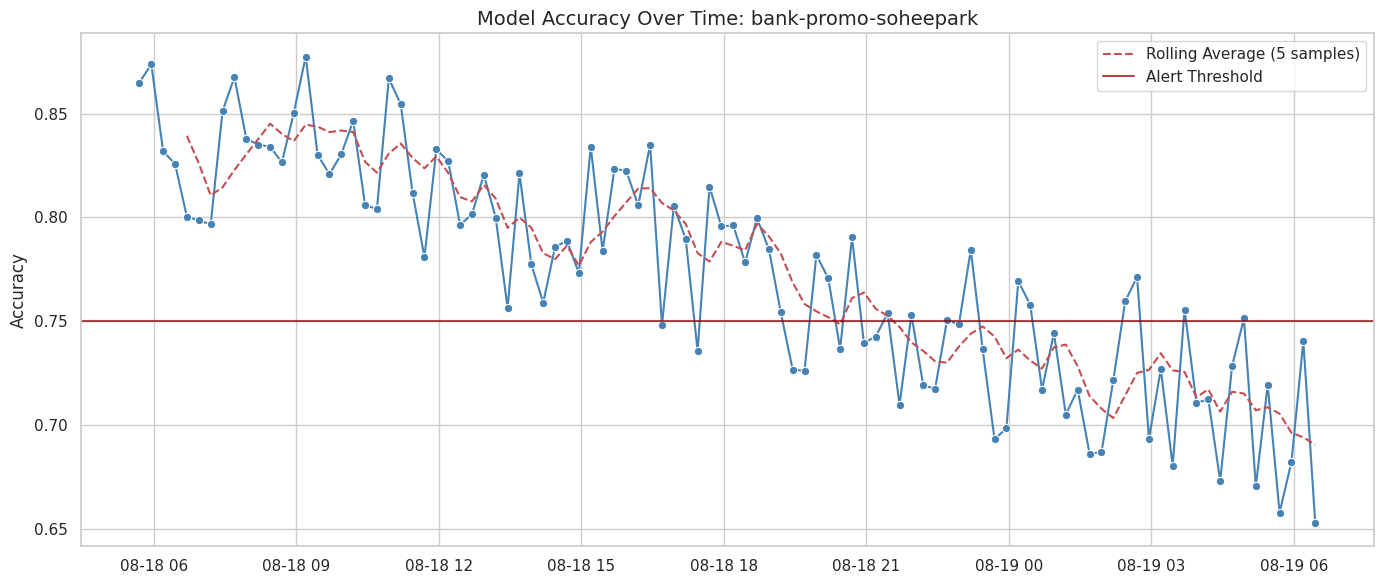

In [6]:
# Set up figure layout for first plot
plt.figure(figsize=(14, 6))
plt.title(f"Model Accuracy Over Time: {MODEL_NAME}", fontsize=14)

if "accuracy" in df.columns:
    sns.lineplot(x="timestamp", y="accuracy", data=df, marker='o', color='steelblue')
    plt.ylabel("Accuracy")
    plt.xlabel("")
    
    # Add rolling average line
    rolling_acc = df["accuracy"].rolling(window=5).mean()
    plt.plot(df["timestamp"], rolling_acc, 'r--', label='Rolling Average (5 samples)')
    
    # Add threshold line
    plt.axhline(y=0.75, color='darkred', linestyle='-', alpha=0.7, label='Alert Threshold')
    plt.legend()
else:
    plt.text(0.5, 0.5, "No accuracy data available", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.show()

## 시각화 2: 처리 시간 추세

이 플롯은 모델의 처리 시간이 어떻게 변했는지 보여주며, 이를 통해 성능 저하를 파악할 수 있습니다.

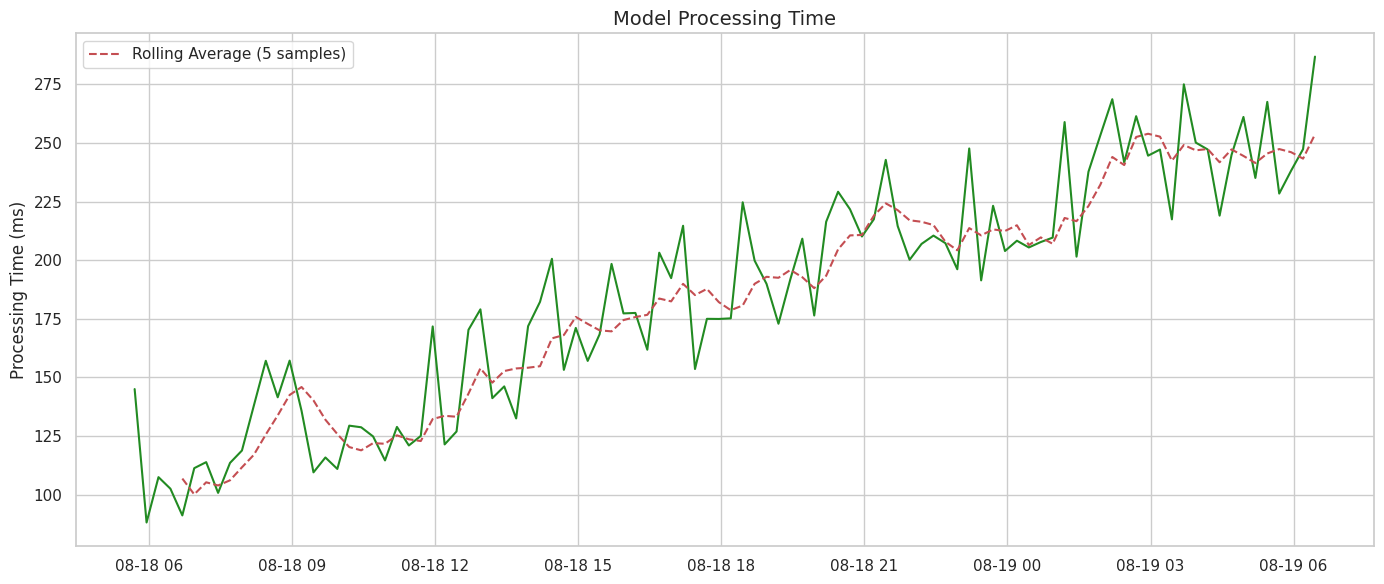

In [7]:
# Set up figure for second plot
plt.figure(figsize=(14, 6))
plt.title(f"Model Processing Time", fontsize=14)

if "processing_time" in df.columns:
    sns.lineplot(x="timestamp", y="processing_time", data=df, color='forestgreen')
    plt.ylabel("Processing Time (ms)")
    plt.xlabel("")
    
    # Add rolling average line
    rolling_time = df["processing_time"].rolling(window=5).mean()
    plt.plot(df["timestamp"], rolling_time, 'r--', label='Rolling Average (5 samples)')
    plt.legend()
else:
    plt.text(0.5, 0.5, "No processing time data available", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.show()

## 시각화 3: 여러 지표 비교

이 플롯은 여러 성능 지표를 비교하여 모델 상태에 대한 포괄적인 정보를 제공합니다.

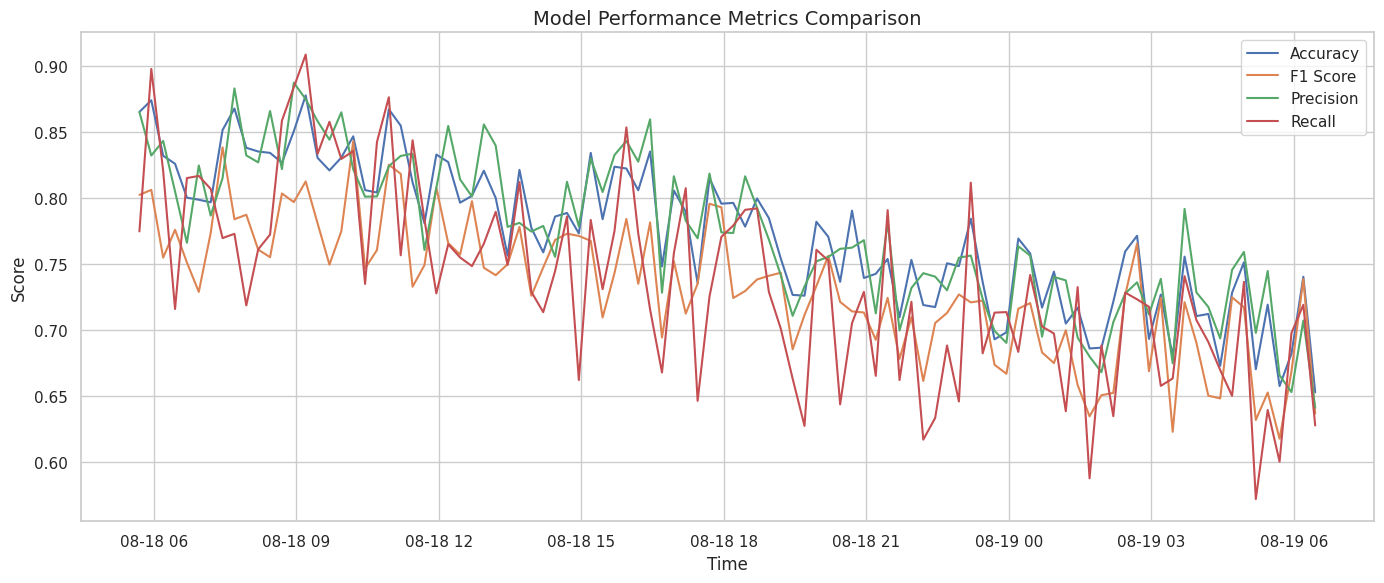

In [8]:
# Set up figure for third plot
plt.figure(figsize=(14, 6))
plt.title("Model Performance Metrics Comparison", fontsize=14)

metrics_to_plot = [col for col in ["accuracy", "f1_score", "precision", "recall"] if col in df.columns]

if metrics_to_plot:
    for metric in metrics_to_plot:
        sns.lineplot(x="timestamp", y=metric, data=df, label=metric.replace("_", " ").title())
    
    plt.ylabel("Score")
    plt.xlabel("Time")
    plt.legend()
else:
    plt.text(0.5, 0.5, "No comparative metrics available", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.show()

## 통합 대시보드 뷰

마지막으로, 모든 플롯을 하나로 모아서 종합적인 대시보드 뷰를 만들고 파일에 저장해 보겠습니다.

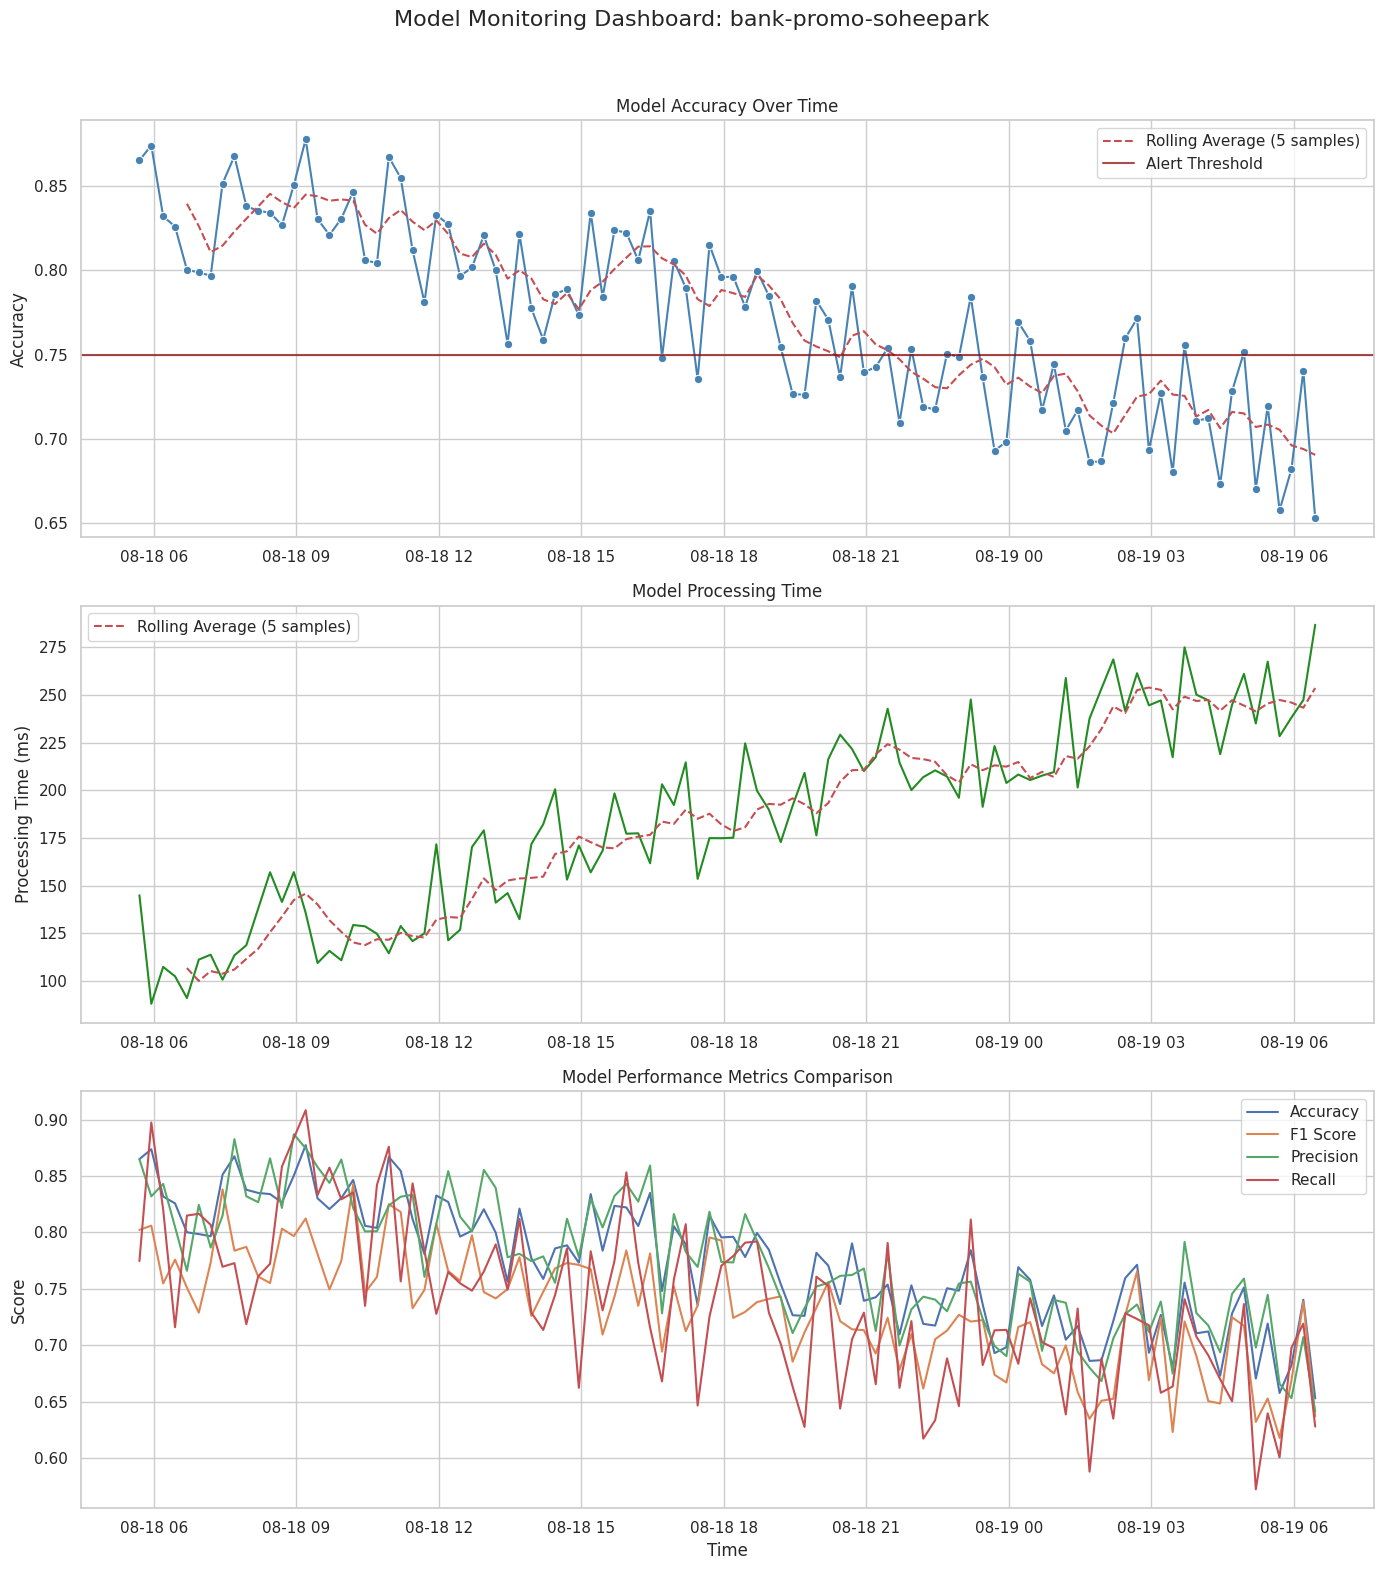


Dashboard generated successfully!
A visualization image has been saved as 'model_monitoring_dashboard.png'


In [9]:
# Set up figure layout for all plots combined
fig = plt.figure(figsize=(14, 16))
fig.suptitle(f"Model Monitoring Dashboard: {MODEL_NAME}", fontsize=16)

# 1. Model Accuracy Over Time
ax1 = plt.subplot(3, 1, 1)
if "accuracy" in df.columns:
    sns.lineplot(x="timestamp", y="accuracy", data=df, ax=ax1, marker='o', color='steelblue')
    ax1.set_title("Model Accuracy Over Time")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("")
    
    # Add rolling average line
    rolling_acc = df["accuracy"].rolling(window=5).mean()
    plt.plot(df["timestamp"], rolling_acc, 'r--', label='Rolling Average (5 samples)')
    
    # Add threshold line
    plt.axhline(y=0.75, color='darkred', linestyle='-', alpha=0.7, label='Alert Threshold')
    plt.legend()
else:
    ax1.text(0.5, 0.5, "No accuracy data available", 
             horizontalalignment='center', verticalalignment='center',
             transform=ax1.transAxes, fontsize=14)

# 2. Processing Time Trend
ax2 = plt.subplot(3, 1, 2)
if "processing_time" in df.columns:
    sns.lineplot(x="timestamp", y="processing_time", data=df, ax=ax2, color='forestgreen')
    ax2.set_title("Model Processing Time")
    ax2.set_ylabel("Processing Time (ms)")
    ax2.set_xlabel("")
    
    # Add rolling average line
    rolling_time = df["processing_time"].rolling(window=5).mean()
    plt.plot(df["timestamp"], rolling_time, 'r--', label='Rolling Average (5 samples)')
    plt.legend()
else:
    ax2.text(0.5, 0.5, "No processing time data available", 
             horizontalalignment='center', verticalalignment='center',
             transform=ax2.transAxes, fontsize=14)

# 3. Multiple Metrics Comparison
ax3 = plt.subplot(3, 1, 3)
metrics_to_plot = [col for col in ["accuracy", "f1_score", "precision", "recall"] if col in df.columns]

if metrics_to_plot:
    for metric in metrics_to_plot:
        sns.lineplot(x="timestamp", y=metric, data=df, label=metric.replace("_", " ").title(), ax=ax3)
    
    ax3.set_title("Model Performance Metrics Comparison")
    ax3.set_ylabel("Score")
    ax3.set_xlabel("Time")
    plt.legend()
else:
    ax3.text(0.5, 0.5, "No comparative metrics available", 
             horizontalalignment='center', verticalalignment='center',
             transform=ax3.transAxes, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.savefig('model_monitoring_dashboard.png')
plt.show()

print("\nDashboard generated successfully!")
print("A visualization image has been saved as 'model_monitoring_dashboard.png'")

## Conclusion

In this notebook, we've created a comprehensive dashboard for monitoring the performance of our bank marketing model. Key insights from the dashboard include:

- Trends in model accuracy over time
- Processing time patterns that might indicate performance issues
- Comparative analysis of multiple metrics to identify potential areas for model improvement

This dashboard can be run periodically to keep track of model health and identify when retraining might be necessary.